### 载入库

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 读取数据

In [3]:
COLUMNS = ["id", "x", "z", "y", "t", "vx", "vz", "vy", "ax", "az", "ay"]

def _read_one_file(file_path):
    """
    读取单个文件，优先用逗号分隔；若列数不为11则退回空白分隔。
    返回一个DataFrame（列名已设置）。
    """
    # 方案A：逗号
    df = pd.read_csv(file_path, sep=",", header=None, engine="python")
    if df.shape[1] != 11:
        # 方案B：空白
        df = pd.read_csv(file_path, sep=r"\s+", header=None, engine="python")
    if df.shape[1] != 11:
        raise ValueError(f"{os.path.basename(file_path)} 读取后列数为 {df.shape[1]}，应为11。请检查文件内容与分隔符。")
    df.columns = COLUMNS
    # 尝试转为数值（若存在无法转换的字符串，会变为NaN）
    for col in COLUMNS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def read_swarm_batch(folder, start=1, end=19, prefix="Ob", ext=".txt", assign_to_locals=False):
    """
    批量读取 Ob{start}.txt ~ Ob{end}.txt
    返回: dict, 形如 {"df1": DataFrame, ..., "df19": DataFrame}
    参数:
      - folder: 含有这些文件的目录
      - start, end: 文件编号范围（闭区间）
      - prefix, ext: 文件名前缀与扩展名
      - assign_to_locals: 若为 True，则把 df1..dfN 注入到调用者的局部变量（一般不建议在函数里这么做，默认False）
    """
    result = {}
    for i in range(start, end + 1):
        filename = f"{prefix}{i}{ext}"
        path = os.path.join(folder, filename)
        if not os.path.isfile(path):
            raise FileNotFoundError(f"未找到文件: {path}")
        df = _read_one_file(path)
        result[f"df{i}"] = df

    # 可选：把 df1..dfN 注入到上层调用环境（不推荐，默认关闭）
    if assign_to_locals:
        import inspect
        frame = inspect.currentframe().f_back
        frame.f_locals.update(result)
    return result


### 数据路径与数据集

In [4]:
folder = r"D:/3Ddataset/"
dfs = read_swarm_batch(folder)     # 返回一个字典
# 如果你想直接得到 df1..df19 变量：
locals().update(dfs)

# 例子：看一下 Ob5（df5）的前几行
print(df5.head(2))

# 例子：快速检查每个文件的基本信息
for name, d in dfs.items():
    print(name, d.shape, "time range:", (d["t"].min(), d["t"].max()))


   id       x       z       y     t      vx      vz      vy      ax      az  \
0   1 -57.204 -48.083  9.2882  0.06 -38.500 -51.608 -179.45  1925.4 -422.75   
1   1 -56.760 -48.610  8.0285  0.07 -18.618 -52.625 -172.98  2869.9  169.95   

       ay  
0  937.77  
1  588.03  
df1 (1028316, 11) time range: (np.float64(0.07), np.float64(109.95))
df2 (1014756, 11) time range: (np.float64(0.07), np.float64(148.65))
df3 (684649, 11) time range: (np.float64(0.06), np.float64(149.95))
df4 (439216, 11) time range: (np.float64(0.06), np.float64(149.95))
df5 (334044, 11) time range: (np.float64(0.06), np.float64(149.95))
df6 (362189, 11) time range: (np.float64(0.05), np.float64(199.95))
df7 (582768, 11) time range: (np.float64(0.04), np.float64(99.95))
df8 (512138, 11) time range: (np.float64(0.07), np.float64(189.95))
df9 (491095, 11) time range: (np.float64(0.07), np.float64(99.95))
df10 (1061152, 11) time range: (np.float64(0.05), np.float64(149.95))
df11 (284772, 11) time range: (np.float64(0.

# 🧩 实验数据分析提纲 —— Sinhuber et al. (2019)

## 🎯 总体目标
基于 19 个实验（Ob1–Ob19）的昆虫群体三维轨迹数据，完成：
1. **数据结构与质量检查**
2. **群体与个体层面的统计特征构建**
3. **动态变化与相关性分析**
4. **为后续 IBM 模型建立参数与目标特征参考**

---

## 🧱 第 1 部分：数据概览与质量检查

### 1.1 读取数据与初步检查
- 查看每个文件（Ob1–Ob19）的基本信息  
  - 行数（样本量）  
  - 时间范围 (`t_min`, `t_max`)  
  - 平均群体规模（独立 `id` 数量）  
- 检查缺失值与异常值（例如速度/加速度中的 NaN 或极端值）

,Dataset,Rows,IDs,t_min,t_max,Duration (s),Missing Values
0,Ob1,1028316,4588,0.070000,109.950000,109.880000,0
1,Ob2,1014756,5242,0.070000,148.650000,148.580000,0
2,Ob3,684649,4228,0.060000,149.950000,149.890000,0
3,Ob4,439216,1054,0.060000,149.950000,149.890000,0
4,Ob5,334044,639,0.060000,149.950000,149.890000,0
5,Ob6,362189,711,0.050000,199.950000,199.900000,0
6,Ob7,582768,2688,0.040000,99.950000,99.910000,0
7,Ob8,512138,2639,0.070000,189.950000,189.880000,0
8,Ob9,491095,2239,0.070000,99.950000,99.880000,0
9,Ob10,1061152,3937,0.050000,149.950000,149.900000,0


,count,mean,std,min,1%,25%,50%,75%,99%,max,range,Dataset
vx,1028316.0,-1.615378,194.011060,-1297.00,-410.6985,-150.25000,-0.460905,145.36000,421.5600,1161.70,2458.70,Ob1
vy,1028316.0,-1.874358,178.722499,-1257.40,-364.6085,-123.45000,-23.486000,110.14250,463.1470,1100.90,2358.30,Ob1
vz,1028316.0,-7.028585,146.749358,-883.29,-314.7100,-111.95000,-12.526000,92.30000,351.9385,933.39,1816.68,Ob1
ax,1028316.0,12.643002,1306.729135,-24792.00,-3292.2850,-671.48000,5.410350,685.24250,3375.7850,26813.00,51605.00,Ob1
ay,1028316.0,44.132704,1283.037882,-25605.00,-3219.5000,-620.07250,38.846000,704.20000,3344.2850,25232.00,50837.00,Ob1
az,1028316.0,2.349762,1540.328706,-17732.00,-3731.8850,-910.31250,-38.410500,860.51000,4209.8850,21609.00,39341.00,Ob1
vx,1014756.0,0.163819,169.375586,-1204.20,-412.1645,-115.08000,22.011000,120.12000,346.0300,971.68,2175.88,Ob2
vy,1014756.0,-2.522190,185.966208,-1054.80,-388.0200,-148.60000,-2.950900,142.88250,386.6700,969.81,2024.61,Ob2
vz,1014756.0,-0.411618,129.166501,-1427.40,-285.9700,-89.18825,-1.803350,87.04425,305.1245,746.02,2173.42,Ob2
ax,1014756.0,4.665154,1242.013729,-24132.00,-3189.0000,-636.82250,0.995710,643.91000,3231.6450,29430.00,53562.00,Ob2


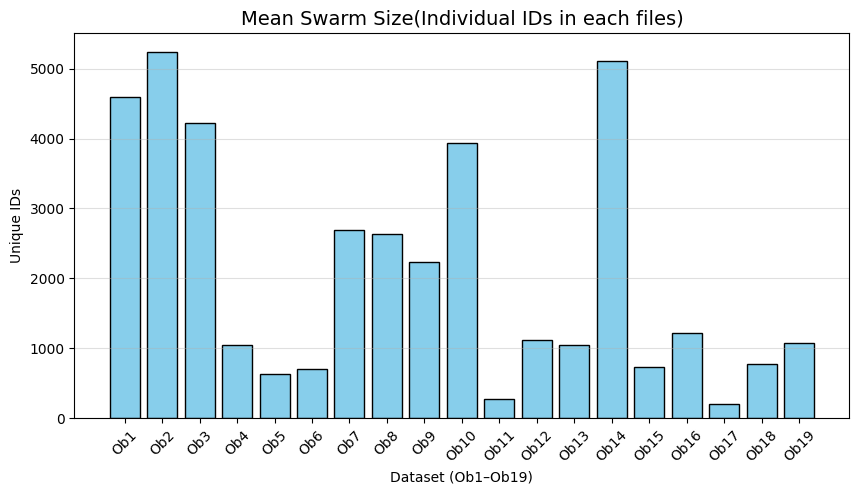

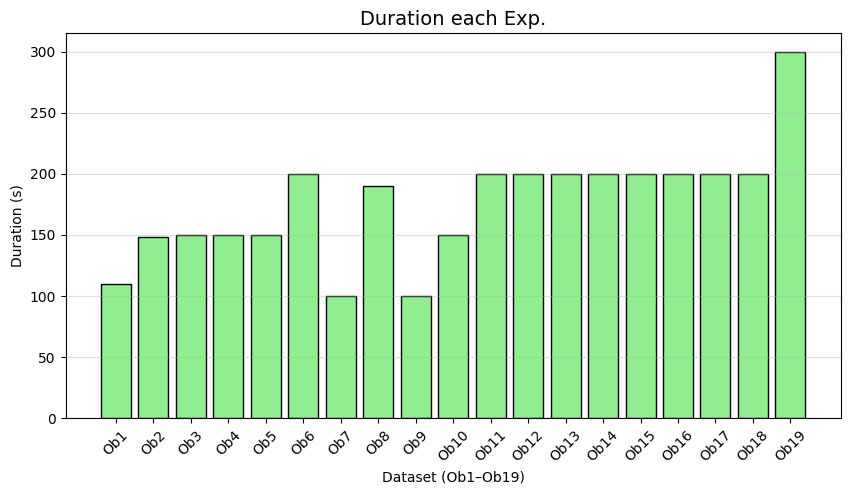

✅ 所有数据集无缺失值。


In [5]:
# 🧩 Part 1.1 数据概览与质量检查

# 1️⃣ 汇总每个数据集的基本信息
summary = []
for i in range(1, 20):
    df = dfs[f"df{i}"]
    n_rows = len(df)
    t_min, t_max = df["t"].min(), df["t"].max()
    duration = t_max - t_min
    n_ids = df["id"].nunique()
    missing = df.isna().sum().sum()

    summary.append({
        "Dataset": f"Ob{i}",
        "Rows": n_rows,
        "IDs": n_ids,
        "t_min": round(t_min, 3),
        "t_max": round(t_max, 3),
        "Duration (s)": round(duration, 3),
        "Missing Values": missing
    })

summary_df = pd.DataFrame(summary)
display(summary_df.style.background_gradient(cmap="Blues"))

# 2️⃣ 检查是否存在异常值（例如速度/加速度中极端值）
def describe_columns(df, cols):
    """返回数值列的统计描述"""
    desc = df[cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T
    desc["range"] = desc["max"] - desc["min"]
    return desc

cols_to_check = ["vx", "vy", "vz", "ax", "ay", "az"]
desc_all = []
for i in range(1, 20):
    df = dfs[f"df{i}"]
    desc = describe_columns(df, cols_to_check)
    desc["Dataset"] = f"Ob{i}"
    desc_all.append(desc)

stats_df = pd.concat(desc_all)
display(stats_df.head(18))

# 3️⃣ 绘制每个数据集的群体规模（个体数量）柱状图
plt.figure(figsize=(10, 5))
plt.bar(summary_df["Dataset"], summary_df["IDs"], color="skyblue", edgecolor="k")
plt.title("Mean Swarm Size(Individual IDs in each files)", fontsize=14)
plt.xlabel("Dataset (Ob1–Ob19)")
plt.ylabel("Unique IDs")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.4)
plt.show()

# 4️⃣ 时间范围与持续时间可视化
plt.figure(figsize=(10, 5))
plt.bar(summary_df["Dataset"], summary_df["Duration (s)"], color="lightgreen", edgecolor="k")
plt.title("Duration each Exp.", fontsize=14)
plt.xlabel("Dataset (Ob1–Ob19)")
plt.ylabel("Duration (s)")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.4)
plt.show()

# 5️⃣ 检查缺失值情况
missing_total = summary_df["Missing Values"].sum()
if missing_total == 0:
    print("✅ 所有数据集无缺失值。")
else:
    print(f"⚠️ 检测到 {missing_total} 个缺失值，请进一步清理。")


### 1.2 坐标与方向系统
- 论文定义：z 轴反向重力方向  
- 记录：x、y、z 的取值范围与相对尺度  
- （可视化）投影图：
  - `x–y`、`x–z`、`y–z` 平面散点可视化  
  - 选取单个个体的轨迹进行轨迹线展示

#### 投影图-3个方向的平面投影

In [6]:
# 🧭 Part 1.2 Coordinate system & projections (XY, XZ, YZ)

def add_speed_accel(df):
    """Add speed |v| and acceleration |a| columns."""
    v = np.sqrt(df["vx"]**2 + df["vy"]**2 + df["vz"]**2)
    a = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)
    df = df.copy()
    df["speed"] = v
    df["accel"] = a
    return df

def center_by_com_each_frame(df):
    """
    Center positions by center-of-mass (per time frame).
    Returns a copy with x_c, y_c, z_c (centered coords) and R_cm(t) for reference.
    """
    df = df.copy()
    com = df.groupby("t")[["x", "y", "z"]].mean().rename(columns={"x":"x_cm", "y":"y_cm", "z":"z_cm"})
    df = df.join(com, on="t")
    df["x_c"] = df["x"] - df["x_cm"]
    df["y_c"] = df["y"] - df["y_cm"]
    df["z_c"] = df["z"] - df["z_cm"]
    return df, com.reset_index()

def plot_projections(df_centered, com_df=None, max_points=300000, gridsize=120):
    """
    Density projections for XY, XZ, YZ.
    df_centered: must contain x_c, y_c, z_c
    """
    # Optional sampling for speed if dataset is huge
    if len(df_centered) > max_points:
        df_plot = df_centered.sample(max_points, random_state=42)
    else:
        df_plot = df_centered

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
    # XY
    hb1 = axes[0].hexbin(df_plot["x_c"], df_plot["y_c"], gridsize=gridsize, bins="log")
    axes[0].set_title("Centered XY Projection (density)")
    axes[0].set_xlabel("x_c (mm)")
    axes[0].set_ylabel("y_c (mm)")
    fig.colorbar(hb1, ax=axes[0], label="log(count)")

    # XZ
    hb2 = axes[1].hexbin(df_plot["x_c"], df_plot["z_c"], gridsize=gridsize, bins="log")
    axes[1].set_title("Centered XZ Projection (density)")
    axes[1].set_xlabel("x_c (mm)")
    axes[1].set_ylabel("z_c (mm)")
    fig.colorbar(hb2, ax=axes[1], label="log(count)")

    # YZ
    hb3 = axes[2].hexbin(df_plot["y_c"], df_plot["z_c"], gridsize=gridsize, bins="log")
    axes[2].set_title("Centered YZ Projection (density)")
    axes[2].set_xlabel("y_c (mm)")
    axes[2].set_ylabel("z_c (mm)")
    fig.colorbar(hb3, ax=axes[2], label="log(count)")

    plt.tight_layout()
    plt.show()

    # Optional: plot COM trajectory on XY (gives a feel for drift before centering)
    if com_df is not None:
        plt.figure(figsize=(5,4))
        plt.plot(com_df["x_cm"] - com_df["x_cm"].mean(),
                 com_df["y_cm"] - com_df["y_cm"].mean(), lw=1)
        plt.title("COM Trajectory (XY, mean-centered)")
        plt.xlabel("x_cm (mm)")
        plt.ylabel("y_cm (mm)")
        plt.gca().set_aspect("equal", adjustable="box")
        plt.grid(alpha=0.3)
        plt.show()

def quick_projections_for(i):
    """
    One-liner helper to run the whole step for Ob{i}.
    Assumes dfs = read_swarm_batch(...) has been run.
    """
    df = dfs[f"df{i}"]
    df = add_speed_accel(df)
    df_c, com = center_by_com_each_frame(df)
    print(f"Ob{i}: rows={len(df)}, unique IDs={df['id'].nunique()}, t=[{df['t'].min():.2f}, {df['t'].max():.2f}] s")
    plot_projections(df_c, com_df=com)

Ob1: rows=1028316, unique IDs=4588, t=[0.07, 109.95] s


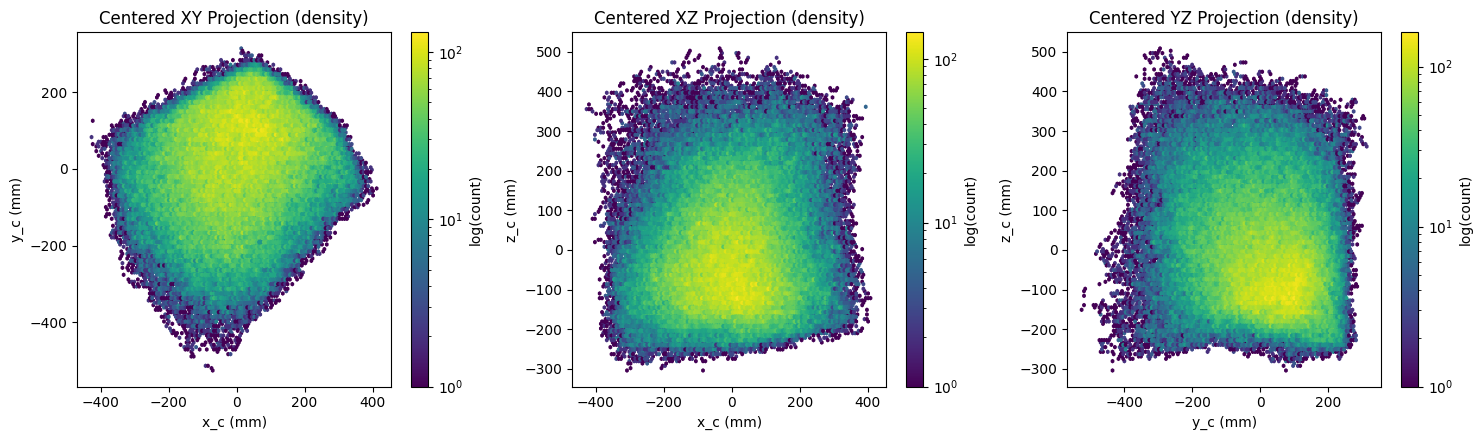

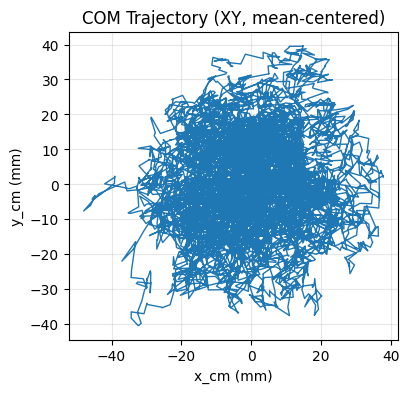

In [7]:
# 👉 Example: run for Ob14 (you can try any index 1..19)
for i in range(1,2):
    quick_projections_for(i)

#### 追踪单个个体轨迹

In [8]:
# 🧵 Part 1.3 Individual trajectories: selection & plotting (projections + optional 3D)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# ---- Utilities ----
def track_lengths(df):
    """Return a DataFrame: id, length (#rows/frames)."""
    return df.groupby("id").size().reset_index(name="length").sort_values("length", ascending=False)

def select_top_k_ids(df, k=1, min_frames=100):
    """
    Select top-k longest tracks, optionally enforcing a minimum number of frames.
    Returns a list of ids.
    """
    tl = track_lengths(df)
    if min_frames is not None:
        tl = tl[tl["length"] >= min_frames]
    return tl.head(k)["id"].tolist()

def to_centered_with_speed_accel(df):
    """Add speed/accel, center by COM per frame; return (df_centered, com_df)."""
    df = df.copy()
    df["speed"] = np.sqrt(df["vx"]**2 + df["vy"]**2 + df["vz"]**2)
    df["accel"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)
    com = df.groupby("t")[["x", "y", "z"]].mean().rename(columns={"x":"x_cm", "y":"y_cm", "z":"z_cm"})
    df = df.join(com, on="t")
    df["x_c"] = df["x"] - df["x_cm"]
    df["y_c"] = df["y"] - df["y_cm"]
    df["z_c"] = df["z"] - df["z_cm"]
    return df, com.reset_index()

# ---- Plotting: 2D projections with time color ramp ----
def plot_trajectories_projections(df_centered, ids, cmap="viridis", alpha=0.9, lw=1.2, max_points_per_id=None):
    """
    Plot XY, XZ, YZ projections for selected ids.
    Colored by normalized time within each id for readability.
    """
    # Prepare figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
    titles = ["XY Projection (centered)", "XZ Projection (centered)", "YZ Projection (centered)"]
    labels = [("x_c (mm)", "y_c (mm)"), ("x_c (mm)", "z_c (mm)"), ("y_c (mm)", "z_c (mm)")]
    pairs = [("x_c", "y_c"), ("x_c", "z_c"), ("y_c", "z_c")]

    # Normalize time per id for color mapping
    for pid in ids:
        sub = df_centered[df_centered["id"] == pid].sort_values("t")
        if max_points_per_id and len(sub) > max_points_per_id:
            sub = sub.iloc[::int(np.ceil(len(sub)/max_points_per_id))]  # simple thinning
        t0, t1 = sub["t"].min(), sub["t"].max()
        if t1 == t0:
            colors = np.zeros(len(sub))
        else:
            colors = (sub["t"] - t0) / (t1 - t0)

        for ax, (a, b), (xl, yl), title in zip(axes, pairs, labels, titles):
            # Build segments for LineCollection (for smooth color gradient)
            pts = sub[[a, b]].to_numpy()
            if len(pts) < 2:
                continue
            segments = np.stack([pts[:-1], pts[1:]], axis=1)
            lc = LineCollection(segments, cmap=cmap, linewidths=lw, alpha=alpha)
            lc.set_array(colors[:-1])
            ax.add_collection(lc)
            ax.set_xlabel(xl)
            ax.set_ylabel(yl)
            ax.set_title(title)
            ax.autoscale()

    for ax in axes:
        ax.set_aspect("equal", adjustable="box")
        ax.grid(alpha=0.3)

    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
    cbar.set_label("Relative time within track")
    plt.tight_layout()
    plt.show()

# ---- Plotting: optional 3D overview ----
def plot_trajectories_3d(df_centered, ids, alpha=0.8, lw=1.0):
    """Simple 3D lines for selected ids (centered coordinates)."""
    fig = plt.figure(figsize=(6.2, 5.6))
    ax = fig.add_subplot(111, projection="3d")
    for pid in ids:
        sub = df_centered[df_centered["id"] == pid].sort_values("t")
        ax.plot(sub["x_c"], sub["y_c"], sub["z_c"], lw=lw, alpha=alpha)
    ax.set_title("3D Trajectories (centered)")
    ax.set_xlabel("x_c (mm)")
    ax.set_ylabel("y_c (mm)")
    ax.set_zlabel("z_c (mm)")
    # Set equal-ish aspect by using data ranges
    x_range = (df_centered["x_c"].min(), df_centered["x_c"].max())
    y_range = (df_centered["y_c"].min(), df_centered["y_c"].max())
    z_range = (df_centered["z_c"].min(), df_centered["z_c"].max())
    max_range = max(x_range[1]-x_range[0], y_range[1]-y_range[0], z_range[1]-z_range[0])
    for rng, setter in zip([x_range, y_range, z_range],
                           [ax.set_xlim, ax.set_ylim, ax.set_zlim]):
        mid = (rng[0]+rng[1])/2
        setter(mid - max_range/2, mid + max_range/2)
    plt.tight_layout()
    plt.show()

# ---- One-click helper: choose IDs and plot ----
def show_tracks_for(dataset_index=14, k=1, min_frames=300, use_3d=True, max_points_per_id=2000):
    """
    For Ob{dataset_index}: select top-k longest tracks (>=min_frames), plot projections; optionally also 3D.
    """
    df = dfs[f"df{dataset_index}"]
    dfc, com = to_centered_with_speed_accel(df)
    ids = select_top_k_ids(dfc, k=k, min_frames=min_frames)
    print(f"Ob{dataset_index}: selected {len(ids)} IDs (top-{k}, min_frames={min_frames}). IDs = {ids[:10]}{'...' if len(ids)>10 else ''}")
    plot_trajectories_projections(dfc, ids, max_points_per_id=max_points_per_id)
    if use_3d:
        plot_trajectories_3d(dfc, ids)

Ob1: selected 1 IDs (top-1, min_frames=400). IDs = [831]


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\262851036.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


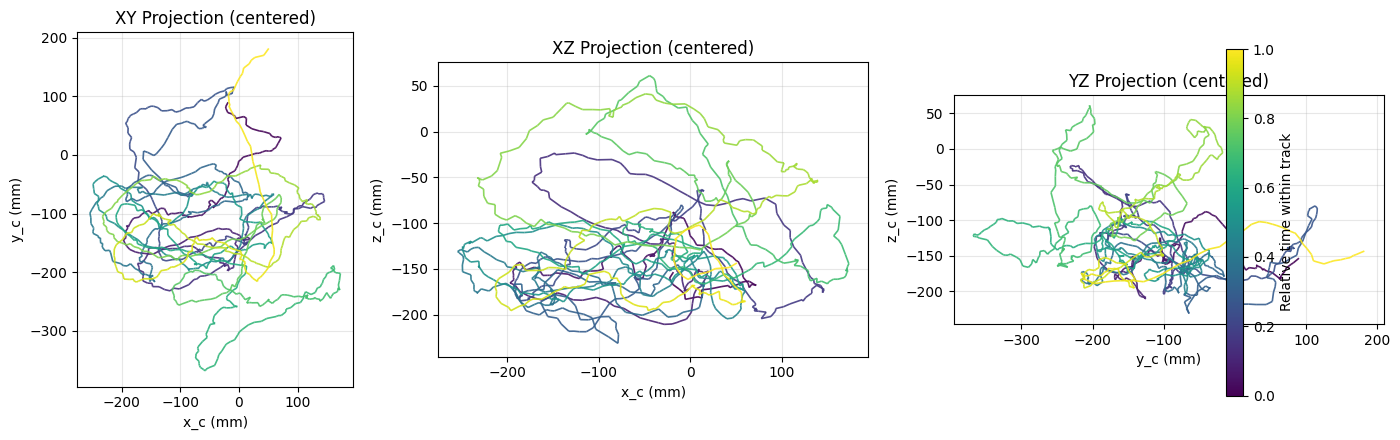

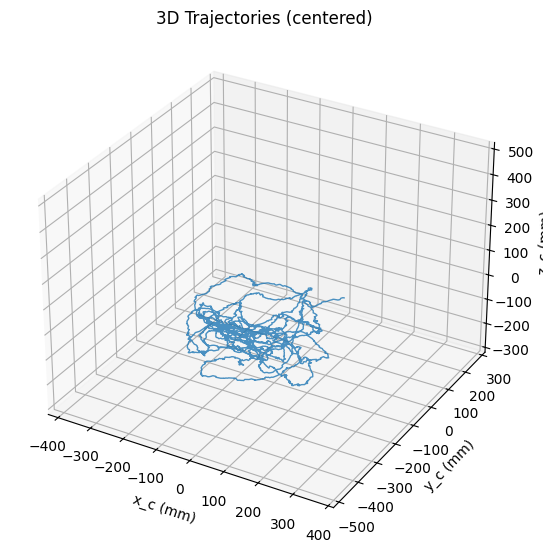

In [9]:
show_tracks_for(dataset_index=1, k=1, min_frames=400, use_3d=True)

---

## 📊 第 2 部分：群体层面统计

### 2.1 群体质心与群体尺度

#### 计算群体质心 $\vec{R}_{cm}(t)$

\begin{equation}
\vec{R}_{cm}(t) = \frac{1}{N(t)} \sum_{i=1}^{N(t)} \vec{r}_i(t)
\tag{1}
\end{equation}

In [10]:
def drift_distance(df = df1):
    grouped = df.groupby("t")
    # 3. 计算群体质心坐标 R_cm(t)
    R_cm = grouped[["x", "y", "z"]].mean().reset_index()
    # 4. 计算质心漂移距离（从初始到末尾）
    R_cm["drift_distance"] = np.sqrt(
        (R_cm["x"] - R_cm["x"].iloc[0])**2 +
        (R_cm["y"] - R_cm["y"].iloc[0])**2 +
        (R_cm["z"] - R_cm["z"].iloc[0])**2
    )

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(R_cm["x"], R_cm["y"], R_cm["z"], lw=2)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_zlabel("z [mm]")
    ax.set_title("Swarm Center-of-Mass Trajectory")
    plt.show()
    # 6. 绘制漂移距离随时间变化
    plt.figure(figsize=(6,4))
    plt.plot(R_cm["t"], R_cm["drift_distance"], color='tab:blue')
    plt.xlabel("Time [s]")
    plt.ylabel("Drift distance [mm]")
    plt.title("Center-of-Mass Drift vs Time")
    plt.show()

    # 7. 输出稳定性指标
    total_drift = R_cm["drift_distance"].iloc[-1]
    print(f"Total drift distance of swarm center: {total_drift:.2f} mm")


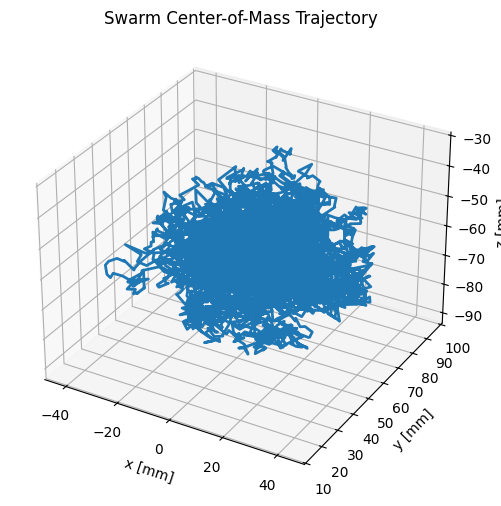

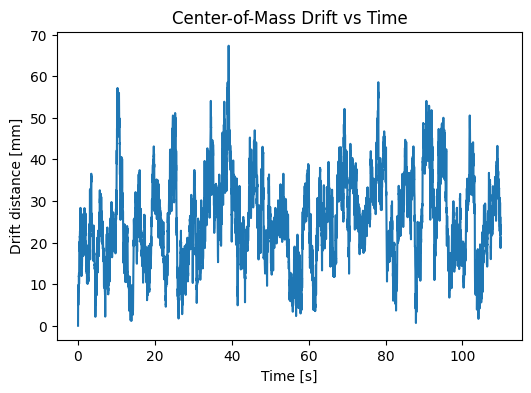

Total drift distance of swarm center: 21.20 mm


In [11]:
drift_distance(df1)

##### 输出说明

- R_cm(t)：群体质心三维轨迹；

- drift_distance(t)：质心相对初始点的漂移距离；

- 若漂移距离远小于群体尺度（后续的 $R_g$），则群体在空间上保持稳定。

#### 计算群体扩散半径 $R_g(t)$（gyration radius） 

\begin{equation}
R_g(t) = \sqrt{\frac{1}{N(t)} \sum_{i=1}^{N(t)} \left|\vec{r}_i(t) - \vec{R}_{cm}(t)\right|^2}
\tag{2}
\end{equation}


In [12]:
def gyration_radius(df, threshold = 0.3, plot=True):
    grouped = df.groupby("t")
    # === 3. 计算群体质心 R_cm(t) ===
    R_cm = grouped[["x", "y", "z"]].mean().reset_index()

    # === 4. 计算群体扩散半径 R_g(t) ===
    # 定义函数：计算每个时刻的 R_g
    def compute_Rg(sub_df):
        x, y, z = sub_df["x"].values, sub_df["y"].values, sub_df["z"].values
        R_cm_t = np.array([x.mean(), y.mean(), z.mean()])
        rg = np.sqrt(np.mean((x - R_cm_t[0])**2 + (y - R_cm_t[1])**2 + (z - R_cm_t[2])**2))
        return rg

    # 对每个时间点计算
    R_cm["Rg"] = grouped.apply(compute_Rg).values

    # === 5. 计算质心漂移距离 ===
    R_cm["drift_distance"] = np.sqrt(
        (R_cm["x"] - R_cm["x"].iloc[0])**2 +
        (R_cm["y"] - R_cm["y"].iloc[0])**2 +
        (R_cm["z"] - R_cm["z"].iloc[0])**2
    )

    # === 6. 可视化 ===
    if plot == True:
        ## (a) 质心三维轨迹
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(R_cm["x"], R_cm["y"], R_cm["z"], lw=2, color='tab:orange')
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("y [mm]")
        ax.set_zlabel("z [mm]")
        ax.set_title("Swarm Center-of-Mass Trajectory")
        plt.show()

        ## (b) 群体尺度 R_g(t) 与漂移距离对比
        plt.figure(figsize=(7,4))
        plt.plot(R_cm["t"], R_cm["Rg"], label=r"$R_g(t)$", color="tab:blue")
        plt.plot(R_cm["t"], R_cm["drift_distance"], label="Drift distance", color="tab:orange", linestyle="--")
        plt.xlabel("Time [s]")
        plt.ylabel("Length scale [mm]")
        plt.title("Swarm Gyration Radius and Center Drift")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # === 7. 输出稳定性指标 ===
        Rg_mean = R_cm["Rg"].mean()
        Rg_std = R_cm["Rg"].std()
        drift_total = R_cm["drift_distance"].iloc[-1]
        stability_ratio = drift_total / Rg_mean

        print(f"Mean R_g: {Rg_mean:.2f} ± {Rg_std:.2f} mm")
        print(f"Total center drift: {drift_total:.2f} mm")
        print(f"Drift / R_g ratio: {stability_ratio:.3f}")
        if stability_ratio < threshold:
            print("✅ Swarm is spatially stable (center drift is small compared to swarm size).")
            eta = 1
        else:
            print("⚠️ Swarm shows noticeable drift; may not be stationary.")
            eta = 0
        return {"mean_Rg": Rg_mean, "drift": drift_total, "Rg_std": Rg_std, "stability_ratio": stability_ratio,"eta":eta}

    else:
        # === 7. 输出稳定性指标 ===
        Rg_mean = R_cm["Rg"].mean()
        Rg_std = R_cm["Rg"].std()
        drift_total = R_cm["drift_distance"].iloc[-1]
        stability_ratio = drift_total / Rg_mean

        #print(f"Mean R_g: {Rg_mean:.2f} ± {Rg_std:.2f} mm")
        #print(f"Total center drift: {drift_total:.2f} mm")
        #print(f"Drift / R_g ratio: {stability_ratio:.3f}")
        if stability_ratio < threshold:
            print("✅ Swarm is spatially stable (center drift is small compared to swarm size).")
            eta =1
        else:
            print("⚠️ Swarm shows noticeable drift; may not be stationary.")
            eta = 0
        return {"mean_Rg": Rg_mean, "drift": drift_total, "Rg_std": Rg_std, "stability_ratio": stability_ratio,"eta":eta}


In [13]:
# === 将 df1–df19 放进一个列表中循环 ===
dfs = [globals()[f"df{i}"] for i in range(1, 20)]

results = []
for i, df in enumerate(dfs, start=1):
    res = gyration_radius(df,threshold=0.1,plot=False)
    res['id'] = f'Ob{i}'
    results.append(res)

# === 汇总结果 ===
summary = pd.DataFrame(results)[["id", "mean_Rg", "drift", "Rg_std", "stability_ratio","eta"]]
print(summary)

C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


✅ Swarm is spatially stable (center drift is small compared to swarm size).


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


✅ Swarm is spatially stable (center drift is small compared to swarm size).


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


⚠️ Swarm shows noticeable drift; may not be stationary.
⚠️ Swarm shows noticeable drift; may not be stationary.
      id     mean_Rg       drift     Rg_std  stability_ratio  eta
0    Ob1  236.784891   21.203743   8.951436         0.089549    1
1    Ob2  232.172890   28.345387  10.977415         0.122087    0
2    Ob3  199.995669   26.919603  14.025494         0.134601    0
3    Ob4  177.630131   63.100550  15.972504         0.355236    0
4    Ob5  153.262066   52.486880  19.995471         0.342465    0
5    Ob6  127.722255  149.530013  18.066952         1.170744    0
6    Ob7  223.325986  220.547414  11.995751         0.987558    0
7    Ob8  193.619921   21.931251  19.753209         0.113270    0
8    Ob9  191.627029    7.623827  12.623538         0.039785    1
9   Ob10  208.802746  282.386417   9.590383         1.352408    0
10  Ob11  124.047578  139.553729  13.923955         1.125002    0
11  Ob12  184.732509  307.712475  16.411205         1.665719    0
12  Ob13  181.671599   52.3340

C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\932013478.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_cm["Rg"] = grouped.apply(compute_Rg).values


##### 输出内容说明

- $R_cm$(t)：群体质心随时间变化（3D轨迹）；

- $R_g$(t)：群体空间尺度（扩散半径）随时间变化；

- drift_distance：质心漂移距离；

- 稳定性判定：

- 若 $\frac{\text{drift}}{R_g} < 0.3$，群体空间上稳定；

- 若较大，则可能存在整体漂移或形态不稳。

### 2.2 群体速度与加速度

- 计算群体平均速度 $\langle v \rangle$ 与平均加速度 $\langle a \rangle$  

\begin{equation}
\langle v \rangle (t) = \frac{1}{N(t)} \sum_{i=1}^{N(t)} |\vec{v}_i(t)|
\tag{3}
\end{equation}


\begin{equation}
\langle a \rangle (t) = \frac{1}{N(t)} \sum_{i=1}^{N(t)} |\vec{a}_i(t)|
\tag{4}
\end{equation}


In [14]:
def analyze_velocity_acceleration(df, show_plot=True):
    grouped = df.groupby("t")

    # === 1. 计算速度模量与加速度模量 ===
    df["speed"] = np.sqrt(df["vx"]**2 + df["vy"]**2 + df["vz"]**2)
    df["accel"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)

    # === 2. 计算群体平均速度与加速度随时间变化 ===
    stats = grouped[["speed", "accel"]].mean().reset_index()
    stats.rename(columns={"speed": "mean_speed", "accel": "mean_accel"}, inplace=True)

    # === 3. 可视化 ===
    if show_plot:
        plt.figure(figsize=(8,4))
        plt.plot(stats["t"], stats["mean_speed"], label=r"$\langle v \rangle (t)$", color="tab:blue")
        plt.plot(stats["t"], stats["mean_accel"], label=r"$\langle a \rangle (t)$", color="tab:orange")
        plt.xlabel("Time [s]")
        plt.ylabel("Magnitude [mm/s or mm/s²]")
        plt.legend()
        plt.title("Swarm mean speed and acceleration vs time")
        plt.tight_layout()
        plt.show()

        # === 4. 概率分布（PDF） ===
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        axs[0].hist(df["speed"], bins=50, density=True, color="tab:blue", alpha=0.7)
        axs[0].set_xlabel("|v| [mm/s]")
        axs[0].set_ylabel("PDF")
        axs[0].set_title("Speed distribution")

        axs[1].hist(df["accel"], bins=50, density=True, color="tab:orange", alpha=0.7)
        axs[1].set_xlabel("|a| [mm/s²]")
        axs[1].set_ylabel("PDF")
        axs[1].set_title("Acceleration distribution")
        plt.tight_layout()
        plt.show()

    # === 5. 输出统计指标 ===
    summary = {
        "mean_speed_global": df["speed"].mean(),
        "std_speed_global": df["speed"].std(),
        "mean_accel_global": df["accel"].mean(),
        "std_accel_global": df["accel"].std()
    }
    return stats, summary


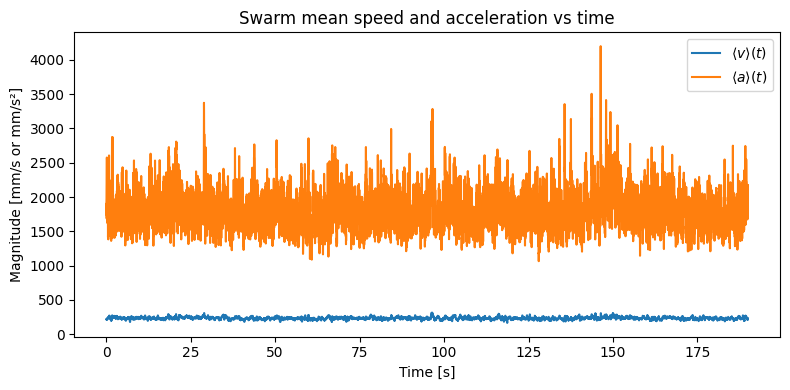

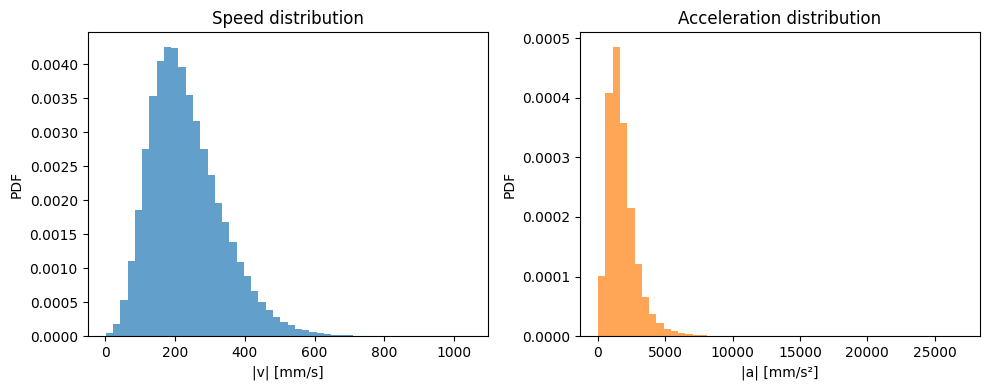

{'mean_speed_global': np.float64(233.18658741821886), 'std_speed_global': np.float64(104.29044922903496), 'mean_accel_global': np.float64(1806.0891107519335), 'std_accel_global': np.float64(1191.3763767084763)}


In [14]:
stats14, summary14 = analyze_velocity_acceleration(df8,show_plot=True)
print(summary14)


- 绘制时间序列曲线（群体平均 vs 时间）  

- 统计速度与加速度的概率分布（PDF）

### 2.3 群体形态

- 计算 x、y、z 三方向的方差比
\begin{equation}
C_{\alpha\beta}(t) = \frac{1}{N(t)} \sum_{i=1}^{N(t)} (r_{i,\alpha}-R_{cm,\alpha})(r_{i,\beta}-R_{cm,\beta})
\tag{5}
\end{equation}


- 评估群体是否具有各向异性（anisotropy）
\begin{equation}
A = \frac{\lambda_{\max}}{\lambda_{\min}}
\tag{6}
\end{equation}


In [15]:
def analyze_swarm_shape(df, show_plot=True):
    grouped = df.groupby("t")

    records = []
    for t, sub_df in grouped:
        # 群体质心
        R_cm = sub_df[["x", "y", "z"]].mean().values
        coords = sub_df[["x", "y", "z"]].values - R_cm

        # 协方差矩阵
        C = np.cov(coords.T)
        eigvals = np.linalg.eigvalsh(C)  # 排序好的特征值 λ1≤λ2≤λ3

        # 方差与各向异性
        sigma2_x, sigma2_y, sigma2_z = np.diag(C)
        anisotropy = eigvals[-1] / eigvals[0]

        records.append({
            "t": t,
            "sigma2_x": sigma2_x,
            "sigma2_y": sigma2_y,
            "sigma2_z": sigma2_z,
            "A": anisotropy
        })

    shape_df = pd.DataFrame(records)

    # === 可视化 ===
    if show_plot:
        plt.figure(figsize=(8,4))
        plt.plot(shape_df["t"], shape_df["sigma2_x"], label=r"$\sigma_x^2$")
        plt.plot(shape_df["t"], shape_df["sigma2_y"], label=r"$\sigma_y^2$")
        plt.plot(shape_df["t"], shape_df["sigma2_z"], label=r"$\sigma_z^2$")
        plt.xlabel("Time [s]")
        plt.ylabel("Variance [mm²]")
        plt.title("Directional variance of swarm shape")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6,4))
        plt.plot(shape_df["t"], shape_df["A"], color="tab:red")
        plt.xlabel("Time [s]")
        plt.ylabel("Anisotropy A = λmax/λmin")
        plt.title("Swarm anisotropy over time")
        plt.tight_layout()
        plt.show()

    # === 汇总统计 ===
    mean_A = shape_df["A"].mean()
    std_A = shape_df["A"].std()
    mean_var_ratio = (shape_df["sigma2_z"].mean() /
                      ((shape_df["sigma2_x"].mean() + shape_df["sigma2_y"].mean()) / 2))

    return shape_df, {
        "mean_A": mean_A,
        "std_A": std_A,
        "mean_var_ratio_z_xy": mean_var_ratio
    }


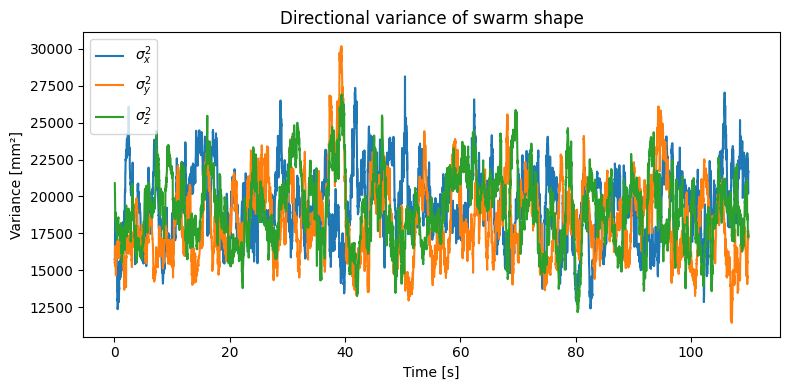

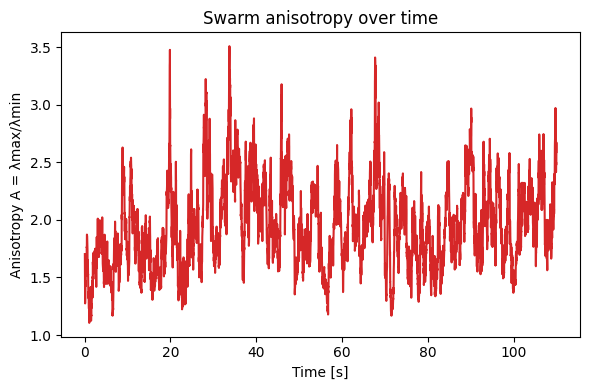

{'mean_A': np.float64(1.9469502214869945), 'std_A': np.float64(0.3711289458721072), 'mean_var_ratio_z_xy': np.float64(1.0112677896179452)}


In [16]:
shape14, shape_summary14 = analyze_swarm_shape(df1)
print(shape_summary14)


---

## 🧬 第 3 部分：个体层面统计）  

### 3.1 轨迹长度与个体活动性
- 每个个体轨迹长度分布(论文指出近似指数分布)
- 平均轨迹长度 vs 群体大小（重现论文图4(b)） 

#### 1 个体轨迹长度（以帧为单位）
实验采样率为 100 Hz

\begin{equation}
L_i = t_{i,\text{last}} - t_{i,\text{first}} = (n_i - 1)\Delta t
\tag{7}
\end{equation}

#### 2 群体平均轨迹长度

\begin{equation}
\langle L \rangle = \frac{1}{N}\sum_i L_i
\tag{8}
\end{equation}


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon, skew, kurtosis

def analyze_trajectory_lengths(df, dt=0.01, show_plot=True):
    # 1️⃣ 计算每个个体的轨迹长度（单位：秒）
    traj_len = df.groupby("id")["t"].agg(lambda t: t.max() - t.min())
    traj_len_sec = traj_len * 1.0  # 已是秒
    traj_len_df = traj_len_sec.reset_index().rename(columns={"t": "traj_length"})

    # 2️⃣ 统计指标
    mean_len = traj_len_df["traj_length"].mean()
    std_len = traj_len_df["traj_length"].std()
    sk = skew(traj_len_df["traj_length"])
    kt = kurtosis(traj_len_df["traj_length"])

    # ✅ 3️⃣ 不论是否绘图，都拟合指数分布
    loc, scale = expon.fit(traj_len_df["traj_length"], floc=0)
    lambda_fit = 1 / scale

    # 4️⃣ 绘制轨迹长度分布（PDF）
    if show_plot:
        plt.figure(figsize=(7,4))
        counts, bins, _ = plt.hist(traj_len_df["traj_length"], bins=40, density=True,
                                   alpha=0.6, color='tab:blue', label="Data")
        x = np.linspace(bins.min(), bins.max(), 200)
        plt.plot(x, expon.pdf(x, loc=0, scale=scale), 'r--',
                 label=f"Exponential fit (λ={lambda_fit:.3f})")
        plt.xlabel("Trajectory length [s]")
        plt.ylabel("PDF")
        plt.title("Trajectory length distribution")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 5️⃣ 绘制CDF
    if show_plot:
        plt.figure(figsize=(6,4))
        sorted_len = np.sort(traj_len_df["traj_length"])
        cdf = np.arange(1, len(sorted_len)+1)/len(sorted_len)
        plt.plot(sorted_len, cdf, lw=2, color="tab:blue")
        plt.xlabel("Trajectory length [s]")
        plt.ylabel("CDF")
        plt.title("Cumulative distribution of trajectory lengths")
        plt.tight_layout()
        plt.show()

    # 6️⃣ 输出结果
    summary = {
        "mean_traj_len": mean_len,
        "std_traj_len": std_len,
        "skewness": sk,
        "kurtosis": kt,
        "exp_lambda": lambda_fit
    }
    return traj_len_df, summary


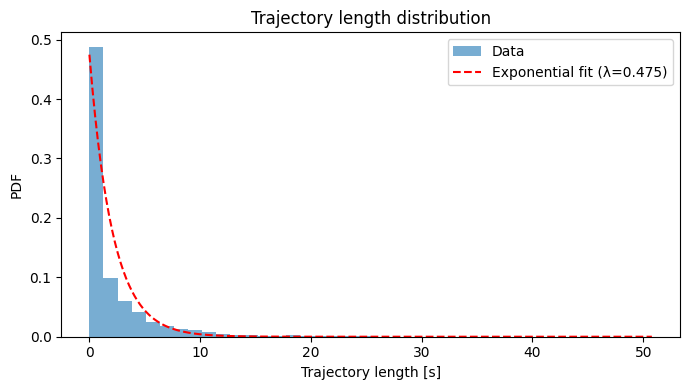

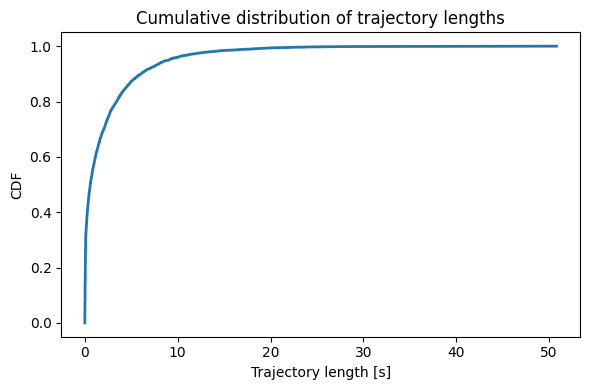

{'mean_traj_len': np.float64(2.1069776995305163), 'std_traj_len': np.float64(3.682729065287719), 'skewness': np.float64(3.8192215863537573), 'kurtosis': np.float64(23.425092046827203), 'exp_lambda': 0.47461347133518467}


In [18]:
traj14, traj_summary14 = analyze_trajectory_lengths(df14)
print(traj_summary14)


In [19]:
results = []
for i in range(1, 20):
    df = globals()[f"df{i}"]
    traj_df, summ = analyze_trajectory_lengths(df, show_plot=False)
    swarm_size = df.groupby("t")["id"].nunique().mean()
    results.append({"id": f"Ob{i}", "mean_track_len": summ["mean_traj_len"],
                    "mean_swarm_size": swarm_size})

summary_len = pd.DataFrame(results)


In [20]:
print(summary_len)

      id  mean_track_len  mean_swarm_size
0    Ob1        2.231316        93.576850
1    Ob2        1.925818        68.292348
2    Ob3        1.609321        45.673716
3    Ob4        4.157135        29.375067
4    Ob5        5.217606        22.333623
5    Ob6        5.084079        18.117603
6    Ob7        2.158036        58.323459
7    Ob8        1.930652        26.970246
8    Ob9        2.183368        49.361242
9   Ob10        2.685331        70.785938
10  Ob11       10.270578        14.245723
11  Ob12        3.342655        18.884892
12  Ob13        5.244357        27.390265
13  Ob14        2.106978        54.139727
14  Ob15        5.483878        20.337519
15  Ob16        5.577193        34.154827
16  Ob17       14.656832        14.820169
17  Ob18        4.922769        19.248387
18  Ob19        8.073663        29.136874


### 3.2 速度与加速度分布
- 个体速度模长 $v_i = \sqrt{vx_i^2 + vy_i^2 + vz_i^2}$  
- 加速度模长 $a_i = \sqrt{ax_i^2 + ay_i^2 + az_i^2}$ 
- 绘制 PDF 与 CDF  
- 计算均值、标准差、偏度、峰度等统计量

\begin{equation}
v_i = \sqrt{v_{x,i}^2 + v_{y,i}^2 + v_{z,i}^2}, \quad
a_i = \sqrt{a_{x,i}^2 + a_{y,i}^2 + a_{z,i}^2}
\tag{9}
\end{equation}


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def analyze_speed_accel_distribution(df, show_plot=True):
    # 1️⃣ 计算速度与加速度模量
    df["speed"] = np.sqrt(df["vx"]**2 + df["vy"]**2 + df["vz"]**2)
    df["accel"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)

    # 2️⃣ 计算统计指标
    stats_summary = {
        "mean_speed": df["speed"].mean(),
        "std_speed": df["speed"].std(),
        "skew_speed": skew(df["speed"]),
        "kurt_speed": kurtosis(df["speed"]),
        "mean_accel": df["accel"].mean(),
        "std_accel": df["accel"].std(),
        "skew_accel": skew(df["accel"]),
        "kurt_accel": kurtosis(df["accel"])
    }

    # 3️⃣ 可视化：PDF（直方图）
    if show_plot:
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        axs[0].hist(df["speed"], bins=80, density=True, color="tab:blue", alpha=0.7)
        axs[0].set_xlabel("|v| [mm/s]")
        axs[0].set_ylabel("PDF")
        axs[0].set_title("Speed distribution")

        axs[1].hist(df["accel"], bins=80, density=True, color="tab:orange", alpha=0.7)
        axs[1].set_xlabel("|a| [mm/s²]")
        axs[1].set_ylabel("PDF")
        axs[1].set_title("Acceleration distribution")

        plt.tight_layout()
        plt.show()

    # 4️⃣ 可视化：CDF
    if show_plot:
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        for i, (col, color, label) in enumerate(zip(
            ["speed", "accel"], ["tab:blue", "tab:orange"], ["Speed", "Acceleration"]
        )):
            sorted_data = np.sort(df[col])
            cdf = np.arange(1, len(sorted_data)+1)/len(sorted_data)
            axs[i].plot(sorted_data, cdf, color=color)
            axs[i].set_xlabel(f"|{label[0].lower()}|")
            axs[i].set_ylabel("CDF")
            axs[i].set_title(f"{label} cumulative distribution")
        plt.tight_layout()
        plt.show()

    return stats_summary


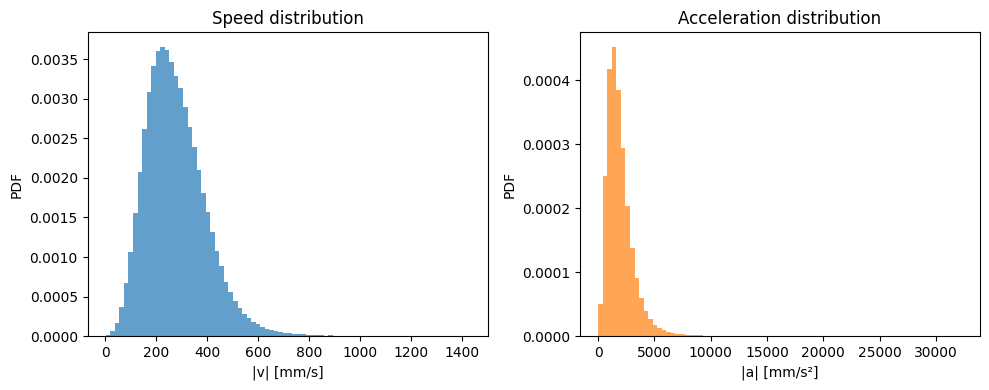

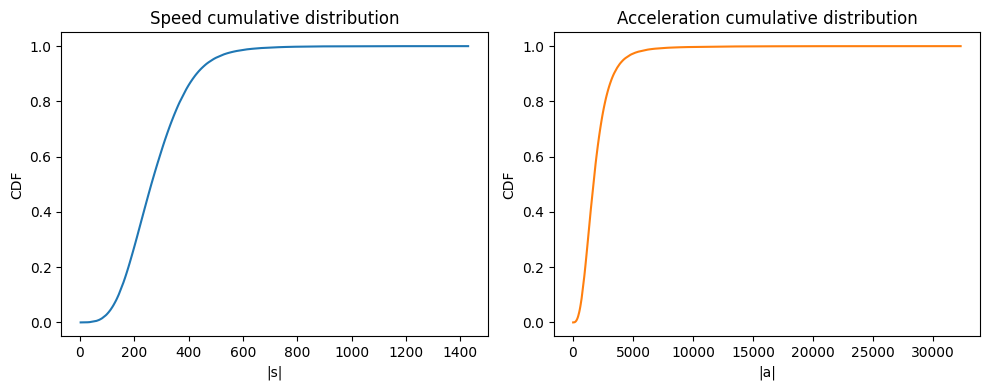

{'mean_speed': np.float64(277.84896451082784),
 'std_speed': np.float64(118.20659273476772),
 'skew_speed': np.float64(0.9749591230829411),
 'kurt_speed': np.float64(2.2467466241000826),
 'mean_accel': np.float64(1978.1782560794388),
 'std_accel': np.float64(1347.315779062039),
 'skew_accel': np.float64(3.572928281885885),
 'kurt_accel': np.float64(29.731753772949084)}

In [22]:
analyze_speed_accel_distribution(df1)

### 3.3 局部邻域与密度
- 对每个个体计算邻域距离分布（可选）  
- 估算局部密度与局部速度对齐度（alignment）

In [23]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

def analyze_local_alignment(df, rc_factor=0.1, show_plot=True):
    grouped = df.groupby("t")

    all_nn_dist = []
    all_alignment = []
    times = []

    for t, sub_df in grouped:
        positions = sub_df[["x", "y", "z"]].values
        velocities = sub_df[["vx", "vy", "vz"]].values
        N = len(sub_df)
        if N < 3:
            continue

        # 估计群体扩散半径 Rg(t)
        R_cm = positions.mean(axis=0)
        Rg = np.sqrt(np.mean(np.sum((positions - R_cm)**2, axis=1)))

        rc = rc_factor * Rg  # 邻域半径
        tree = cKDTree(positions)

        # 最近邻距离
        dists, _ = tree.query(positions, k=2)  # 自身+最近邻
        mean_nn = np.mean(dists[:, 1])
        all_nn_dist.append(mean_nn)

        # 局部对齐度
        phi_list = []
        for i in range(N):
            idxs = tree.query_ball_point(positions[i], rc)
            if len(idxs) <= 1:
                continue
            vi = velocities[i]
            vj = velocities[idxs]
            dot = np.dot(vj, vi)
            norm = np.linalg.norm(vj, axis=1) * np.linalg.norm(vi)
            phi_i = np.mean(dot / norm)
            phi_list.append(phi_i)

        mean_phi = np.nanmean(phi_list)
        all_alignment.append(mean_phi)
        times.append(t)

    # === 汇总 ===
    result = pd.DataFrame({
        "t": times,
        "mean_nn_distance": all_nn_dist,
        "mean_alignment": all_alignment
    })

    if show_plot:
        fig, ax1 = plt.subplots(figsize=(8,4))
        ax1.plot(result["t"], result["mean_nn_distance"], color="tab:blue", label="Mean NN distance")
        ax1.set_xlabel("Time [s]")
        ax1.set_ylabel("Distance [mm]", color="tab:blue")
        ax2 = ax1.twinx()
        ax2.plot(result["t"], result["mean_alignment"], color="tab:orange", label="Alignment ⟨ϕ⟩")
        ax2.set_ylabel("Alignment", color="tab:orange")
        plt.title("Local neighborhood and alignment over time")
        plt.tight_layout()
        plt.show()

    summary = {
        "mean_nn_distance": np.mean(all_nn_dist),
        "std_nn_distance": np.std(all_nn_dist),
        "mean_alignment": np.nanmean(all_alignment),
        "std_alignment": np.nanstd(all_alignment)
    }
    return result, summary


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\2908334797.py:45: RuntimeWarning: Mean of empty slice
  mean_phi = np.nanmean(phi_list)
C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\2908334797.py:45: RuntimeWarning: Mean of empty slice
  mean_phi = np.nanmean(phi_list)
C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\2908334797.py:45: RuntimeWarning: Mean of empty slice
  mean_phi = np.nanmean(phi_list)
C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\2908334797.py:45: RuntimeWarning: Mean of empty slice
  mean_phi = np.nanmean(phi_list)
C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\2908334797.py:45: RuntimeWarning: Mean of empty slice
  mean_phi = np.nanmean(phi_list)
C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\2908334797.py:45: RuntimeWarning: Mean of empty slice
  mean_phi = np.nanmean(phi_list)
C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\2908334797.py:45: RuntimeWarning: Mean of empty slice
  mean_phi = np.nanmean(phi_list)
C:\Users\Saru\AppData\Local\Temp\ipykerne

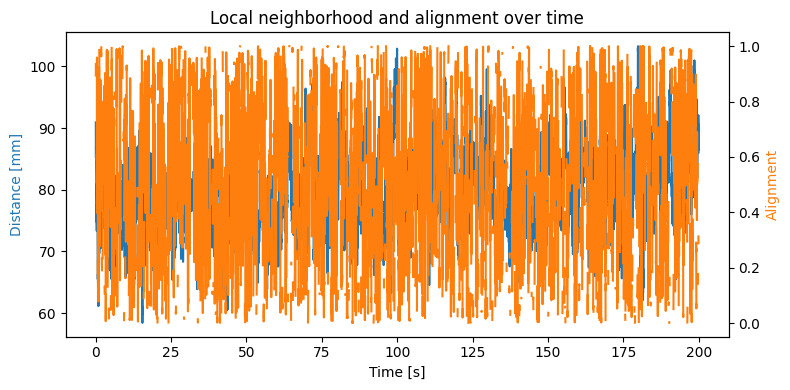

{'mean_nn_distance': np.float64(79.18388307112652), 'std_nn_distance': np.float64(6.25525415987212), 'mean_alignment': np.float64(0.5269615695463635), 'std_alignment': np.float64(0.27233745718937225)}


In [24]:
res14, summary14 = analyze_local_alignment(df14)
print(summary14)


---

## ⏱ 第 4 部分：动态与相关性分

### 4.1 时间自相关函数
- 速度自相关 $C_v(\tau)$  
- 加速度自相关 $C_a(\tau)$  
- 判断群体动力的时间尺度
 

\begin{equation}
C_x(\tau)=\frac{\langle (x(t)-\langle x\rangle)(x(t+\tau)-\langle x\rangle)\rangle}{\langle (x(t)-\langle x\rangle)^2\rangle},\quad x\in\{\;|v|,\;|a|\;\}
\tag{10}
\end{equation}


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _segment_by_constant_dt(t, tol=1e-6):
    """根据恒定步长切段。返回每段的起止索引列表（闭区间）。"""
    t = np.asarray(t)
    if len(t) < 3:
        return [(0, len(t)-1)]
    dt = np.diff(t)
    # 以时间序列的众数近似采样间隔
    dt0 = np.median(dt)
    breaks = np.where(np.abs(dt - dt0) > tol + 5e-3)[0]  # 放宽容忍度，允许极少数抖动
    segments = []
    start = 0
    for b in breaks:
        end = b
        if end - start >= 5:  # 至少 5 点才有意义
            segments.append((start, end))
        start = b + 1
    if len(t)-1 - start >= 4:
        segments.append((start, len(t)-1))
    return segments

def _acf_1d(x, max_lag=None):
    """对 1D 序列计算标准化自相关（带安全截断）。"""
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    n = len(x)
    if n < 8:
        return None
    if max_lag is None:
        max_lag = min(n // 2, 500)
    else:
        # 🔧 修正关键行：不能超过 n-1
        max_lag = min(max_lag, n - 1)

    acf = []
    denom = np.sum(x * x)
    if denom <= 0:
        return None
    for k in range(max_lag + 1):
        num = np.dot(x[:n - k], x[k:])
        acf.append(num / denom)
    return np.array(acf)


def compute_speed_accel_acf(df, max_lag_s=1.0, show_plot=True):
    """
    返回群体速度模量与加速度模量的平均 ACF 以及积分时间尺度。
    max_lag_s: 最大滞后（秒）
    """
    # 计算模量
    speed = np.sqrt(df["vx"]**2 + df["vy"]**2 + df["vz"]**2)
    accel = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)
    dfx = df.copy()
    dfx["speed"] = speed
    dfx["accel"] = accel

    acf_speed_list = []
    acf_accel_list = []
    # 估 dt （用整体中位数）
    dt_global = df.groupby("id")["t"].diff().median()
    dt_global = 0.01 if pd.isna(dt_global) else float(dt_global)
    max_lag_steps = int(max_lag_s / dt_global)

    for pid, g in dfx.sort_values(["id","t"]).groupby("id"):
        t = g["t"].values
        v = g["speed"].values
        a = g["accel"].values
        segments = _segment_by_constant_dt(t)
        for s,e in segments:
            vv = v[s:e+1]
            aa = a[s:e+1]
            acf_v = _acf_1d(vv, max_lag=max_lag_steps)
            acf_a = _acf_1d(aa, max_lag=max_lag_steps)
            if acf_v is not None: acf_speed_list.append(acf_v)
            if acf_a is not None: acf_accel_list.append(acf_a)

    # 对齐并求平均
    def _mean_stack(acfs):
        if len(acfs)==0:
            return None
        L = min(len(x) for x in acfs)
        arr = np.vstack([x[:L] for x in acfs])
        return arr.mean(axis=0)

    mean_acf_speed = _mean_stack(acf_speed_list)
    mean_acf_accel = _mean_stack(acf_accel_list)
    lags = np.arange(len(mean_acf_speed)) * dt_global if mean_acf_speed is not None else None

    # 积分时间尺度（到第一次过零点为止的正部分）
    def _integral_timescale(acf, dt):
        if acf is None: return np.nan
        # 找第一次过零
        z = np.where(acf<=0)[0]
        last = z[0] if len(z)>0 else len(acf)-1
        return np.trapz(np.maximum(acf[:last+1],0), dx=dt)

    tau_v = _integral_timescale(mean_acf_speed, dt_global)
    tau_a = _integral_timescale(mean_acf_accel, dt_global)

    if show_plot and (lags is not None):
        plt.figure(figsize=(7,4))
        plt.plot(lags, mean_acf_speed, label=r"$C_v(\tau)$")
        plt.plot(lags, mean_acf_accel, label=r"$C_a(\tau)$")
        plt.xlabel("Lag τ [s]")
        plt.ylabel("Autocorrelation")
        plt.title(f"Speed/Acceleration ACF, τ_v={tau_v:.3f}s, τ_a={tau_a:.3f}s")
        plt.legend(); plt.tight_layout(); plt.show()

    return {
        "lags": lags,
        "C_v": mean_acf_speed,
        "C_a": mean_acf_accel,
        "tau_v": tau_v,
        "tau_a": tau_a,
        "dt": dt_global
    }


### 4.2 群体整体能量指标
- 平均动能 $E_k = \frac{1}{2}m \langle v^2 \rangle$（可相对化）  
- 动能波动与群体稳定性指标  

\begin{equation}
E_k^{\mathrm{rel}}(t)=\frac{1}{2}\langle v^2\rangle(t)=\frac{1}{2N(t)}\sum_{i=1}^{N(t)}|\vec v_i(t)|^2
\tag{11}
\end{equation}


In [26]:
def compute_relative_kinetic_energy(df, show_plot=True):
    dfk = df.copy()
    dfk["v2"] = dfk["vx"]**2 + dfk["vy"]**2 + dfk["vz"]**2
    ek = dfk.groupby("t")["v2"].mean() * 0.5  # 相对动能
    ek = ek.reset_index().rename(columns={"v2":"Ek_rel"})

    Ek_mean = ek["Ek_rel"].mean()
    Ek_std  = ek["Ek_rel"].std()
    cv = Ek_std / Ek_mean if Ek_mean>0 else np.nan  # 变异系数，波动强度

    if show_plot:
        plt.figure(figsize=(8,4))
        plt.plot(ek["t"], ek["Ek_rel"])
        plt.xlabel("Time [s]"); plt.ylabel("Relative kinetic energy")
        plt.title(f"Relative kinetic energy time series (mean={Ek_mean:.2f}, CV={cv:.3f})")
        plt.tight_layout(); plt.show()

    return ek, {"Ek_mean": Ek_mean, "Ek_std": Ek_std, "Ek_CV": cv}


### 4.3 速度协方差矩阵与主成分分析
- 计算速度协方差矩阵  
- PCA 分析主要运动方向（群体“主运动模态”）

\begin{equation}
\Sigma_v(t)=\frac{1}{N(t)}\sum_{i=1}^{N(t)}\left(\vec v_i(t)-\langle \vec v\rangle(t)\right)\left(\vec v_i(t)-\langle \vec v\rangle(t)\right)^{\!\top}
\tag{12}
\end{equation}


In [27]:
def velocity_pca(df, show_plot=True):
    rec = []
    for t, g in df.groupby("t"):
        V = g[["vx","vy","vz"]].values
        if len(V) < 3: 
            continue
        Vc = V - V.mean(axis=0, keepdims=True)
        C = np.cov(Vc.T, bias=True)  # 3x3
        # 特征分解（eigvalsh 已排序 λ1≤λ2≤λ3）
        w = np.linalg.eigvalsh(C)
        tot = np.sum(w)
        if tot <= 0:
            evr = [np.nan, np.nan, np.nan]
        else:
            evr = (w / tot).tolist()
        rec.append({"t": t, "evr1": evr[0], "evr2": evr[1], "evr3": evr[2]})

    pca_df = pd.DataFrame(rec)
    mean_evr = pca_df[["evr1","evr2","evr3"]].mean().to_dict()

    if show_plot and len(pca_df):
        plt.figure(figsize=(8,4))
        plt.plot(pca_df["t"], pca_df["evr1"], label="PC1 explained var")
        plt.plot(pca_df["t"], pca_df["evr2"], label="PC2 explained var")
        plt.plot(pca_df["t"], pca_df["evr3"], label="PC3 explained var")
        plt.xlabel("Time [s]"); plt.ylabel("Explained variance ratio")
        plt.title("Velocity PCA (per-time explained variance)")
        plt.legend(); plt.tight_layout(); plt.show()

    return pca_df, {"mean_evr": mean_evr}


C:\Users\Saru\AppData\Local\Temp\ipykernel_16980\314786060.py:98: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(np.maximum(acf[:last+1],0), dx=dt)


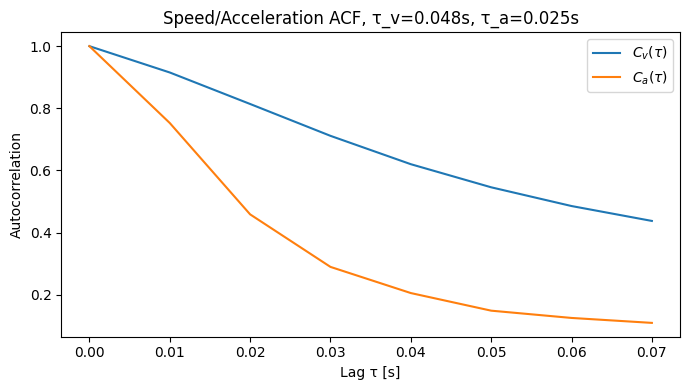

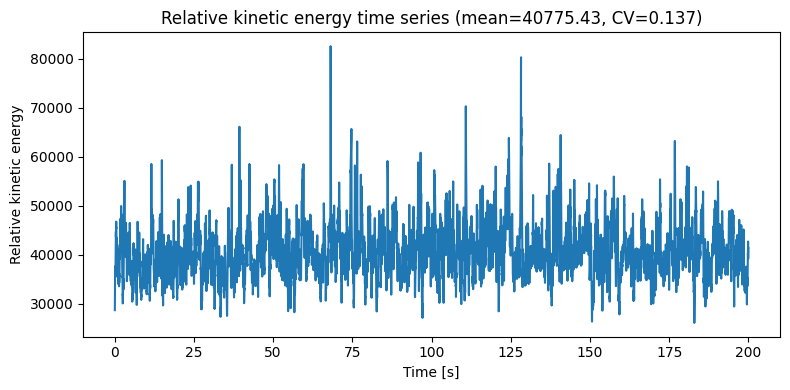

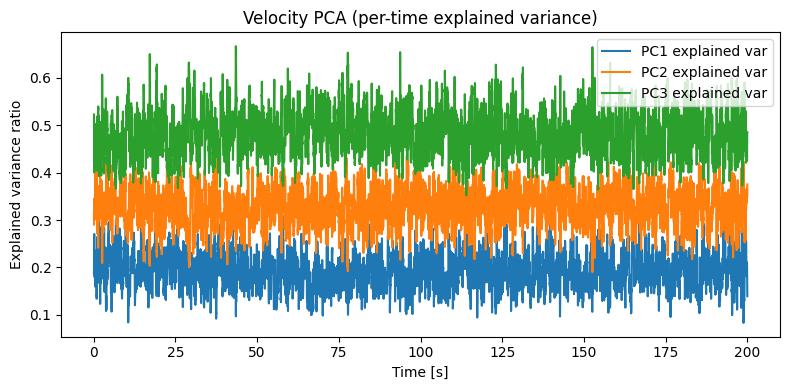

ACF time scales: {'tau_v': np.float64(0.04811108093054002), 'tau_a': np.float64(0.02535712097153598)}
Energy summary: {'Ek_mean': np.float64(40775.42573954673), 'Ek_std': np.float64(5586.681178016766), 'Ek_CV': np.float64(0.1370109833727237)}
PCA mean explained variance: {'evr1': 0.19041491743980954, 'evr2': 0.3266208958307429, 'evr3': 0.48296418672944746}


In [28]:
acf14 = compute_speed_accel_acf(df14, max_lag_s=1.0, show_plot=True)
ek14, ek_sum14 = compute_relative_kinetic_energy(df14, show_plot=True)
pca14, pca_sum14 = velocity_pca(df14, show_plot=True)

print("ACF time scales:", {"tau_v": acf14["tau_v"], "tau_a": acf14["tau_a"]})
print("Energy summary:", ek_sum14)
print("PCA mean explained variance:", pca_sum14["mean_evr"])


---

## 🔧 第 5 部分：结果整合与模型参考指标

### 5.1 汇总每个群体的主要统计量
| 指标 | 含义 | 单位 | 示例值 |
|------|------|------|--------|
| 平均个体数 | 群体规模 | 个 | ~50 |
| 平均
